## 本项目依赖的python包
```
pip install requests
pip install numpy
pip install pandas
pip install matplotlib
pip install tensorflow
pip install keras
```

## 从Kaggle下载数据并解压
运行此段代码前请登录Kaggle, 并且到页面https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/rules 点击同意比较规则。
下载数据时会提示输入用户名和密码。

In [1]:
#================1.retrieve data===========================
import sys
import os
import urllib.request
import getpass
import requests

def verify_datasize(filename, expected_bytes):
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print("Found and verified.", filename)
    else:
        raise Exception("Failed to veryfile file [{}], file_size [{}], expected_size [{}].".format(filename, statinfo.st_size, expected_bytes))

        
#Reports every 5% change in download progress
last_percent_reported = None
def download_progress_hook(count, blockSize, totalSize):
    global last_percent_reported
    percent = int(count * blockSize * 100) / totalSize
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
        else:
            sys.stdout.write(".")
        sys.stdout.flush()
    last_percent_reported = percent

    
#download a file from url and check size
data_root = "." #data saved local directory

urls = [['https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip', 569918665],
      ['https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/test.zip',284478493]]
headers = {
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'
}

def download_data_without_Authentication(url, expected_bytes, force=False):
    dest_filename = os.path.join(data_root,url.split('/')[-1])
    if force or not os.path.exists(dest_filename):
        print("Attempting to download data from :", url)
        urllib.request.urlretrieve(url, dest_filename, download_progress_hook)
        print("\nDownload completed!")
    verify_datasize(dest_filename, expected_bytes)
    return dest_filename

#first you must login to Kaggle, direct to the specific competition, and accept rules competition, or post will direct to rules page.
#eg:dogs-vs-cats's rule page is:https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/rules
def download_data_with_Authentication(url, expected_bytes, force=False):
    dest_filename = os.path.join(data_root, url.split('/')[-1])
    if force or not os.path.exists(dest_filename):
        print("Attempting to download data from :", url)
        user_name = input("Enter username:")
        pwd = getpass.getpass("Enter password:")
        authen_info = {'UserName':user_name, 'Password': pwd}
        
        #To go to the redirect url
        resp = requests.get(url, headers=headers)
        print("Redirected:", resp.url)

        #To login and get data
        resp = requests.post(resp.url, data = authen_info, headers=headers,stream=True)
        print("Redirected:", resp.url)
        print("Status:", resp.status_code)
        
        if resp.status_code == requests.codes.ok:
            f = open(dest_filename, 'wb')
            for chunk in resp.iter_content(chunk_size = 512 * 1024):# Reads 512KB at a time into memory
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
            f.close()
            print("\nDownload completed!")
        else:
            raise Exception("\nDownload failed")
        
    verify_datasize(dest_filename, expected_bytes)
    return dest_filename
   

train_filename = download_data_with_Authentication(urls[0][0], urls[0][1], force=True)
test_filename = download_data_with_Authentication(urls[1][0], urls[1][1], force=True)            

Attempting to download data from : https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip
Enter username:heirish
Enter password:········
Redirected: https://www.kaggle.com/account/login?ReturnUrl=%2fc%2fdogs-vs-cats-redux-kernels-edition%2fdownload%2ftrain.zip
Redirected: https://storage.googleapis.com/kaggle-competitions-data/kaggle/5441/train.zip?GoogleAccessId=competitions-data@kaggle-161607.iam.gserviceaccount.com&Expires=1505372446&Signature=K1WPGGEkhmYfP7pQsFHZZpC5YwdrUR7Ee0e1emXkQVPE%2FvEl6QyzfS5zOXBQ9CsfAQvQHh9h%2Bk9AsAYufBtFCZdSJQ2MFvK74UGSZQo%2FOo5uOYGNYroJ39hXLueun%2Bm%2BmDINZaMDdGZtI3cguTzGykg8lsMeR8MMpk5FqqmuwQ60KhFkjzEgL%2B058Mc%2BAdOWLvclM1KpQjIe6u8EYxuKOMl7dkLiBIjjhXYcIR8T1QJk4IVTMQrMM7mgrn7s19BSUm4Su%2BbOgpz%2Fym93NWIqu3Brsoc1H6kfdy5Jg5wTJzjora71Qb0Yjtd8Az470mZ9utHMU651G9jVknDqOcKFSQ%3D%3D
Status: 200

Download completed!
Found and verified. ./train.zip
Attempting to download data from : https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-editio

In [2]:
#=================2.unzip file and explore image files======================
import zipfile

def unzip_file(filename):
    file_to_unzip = zipfile.ZipFile(filename)
    file_to_unzip.extractall()
    file_to_unzip.close()
    print("Unzip file succeed.", filename)
    
unzip_file(train_filename)
unzip_file(test_filename)
    

Unzip file succeed. ./train.zip
Unzip file succeed. ./test.zip


## 按模型输入要求重新分配数据目录
最终目录结构如下:
```
├─test
│  └─test
├─train
└─trainprocess
    ├─categorized
    │  ├─cat
    │  └─dog
    ├─train
    │  ├─cat
    │  └─dog
    └─valid
        ├─cat
        └─dog
```
其中:
* test是原始测试数据解压以后的目录，并添加了一层同名目录
* train是原始训练数据解压以后的目录
* trainprocess是对训练数据重新按"训练/分类","验证/分类"结构进行存放的目录。其中trianprocess/categorized是临时目录

In [1]:
import os
import shutil
from PIL import Image

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

def rebuild_dir(dir):
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.mkdir(dir)
        
def rearrange_data(category_name):
    if category_name not in categories:
        raise Exception("\n category [{}] not exists.", category_name)
        
    category_data_dir = cate_dat_dir + "/" + category_name
    rebuild_dir(category_data_dir)
    
    train_filenames = os.listdir('./train')
    train_category = filter(lambda x:x[:3].upper() ==category_name.upper() , train_filenames)
    train_count = 0
    for filename in train_category:
        train_count += 1
        shutil.copy("./train/" + filename, category_data_dir)
    return train_count
 
#首次运行时请将此处的屏蔽打开
'''
rebuild_dir(dat_dir)
rebuild_dir(cate_dat_dir)
dog_counts = rearrange_data("dog")
cat_counts = rearrange_data("cat")
'''

'\nrebuild_dir(dat_dir)\nrebuild_dir(cate_dat_dir)\ndog_counts = rearrange_data("dog")\ncat_counts = rearrange_data("cat")\n'

## 探索数据
获取数据集样本数，图片尺寸分布图


dogs group by format, mode:
format  mode
JPEG    RGB     12500
Name: width, dtype: int64

cats group by format, mode:
format  mode
JPEG    RGB     12500
Name: width, dtype: int64


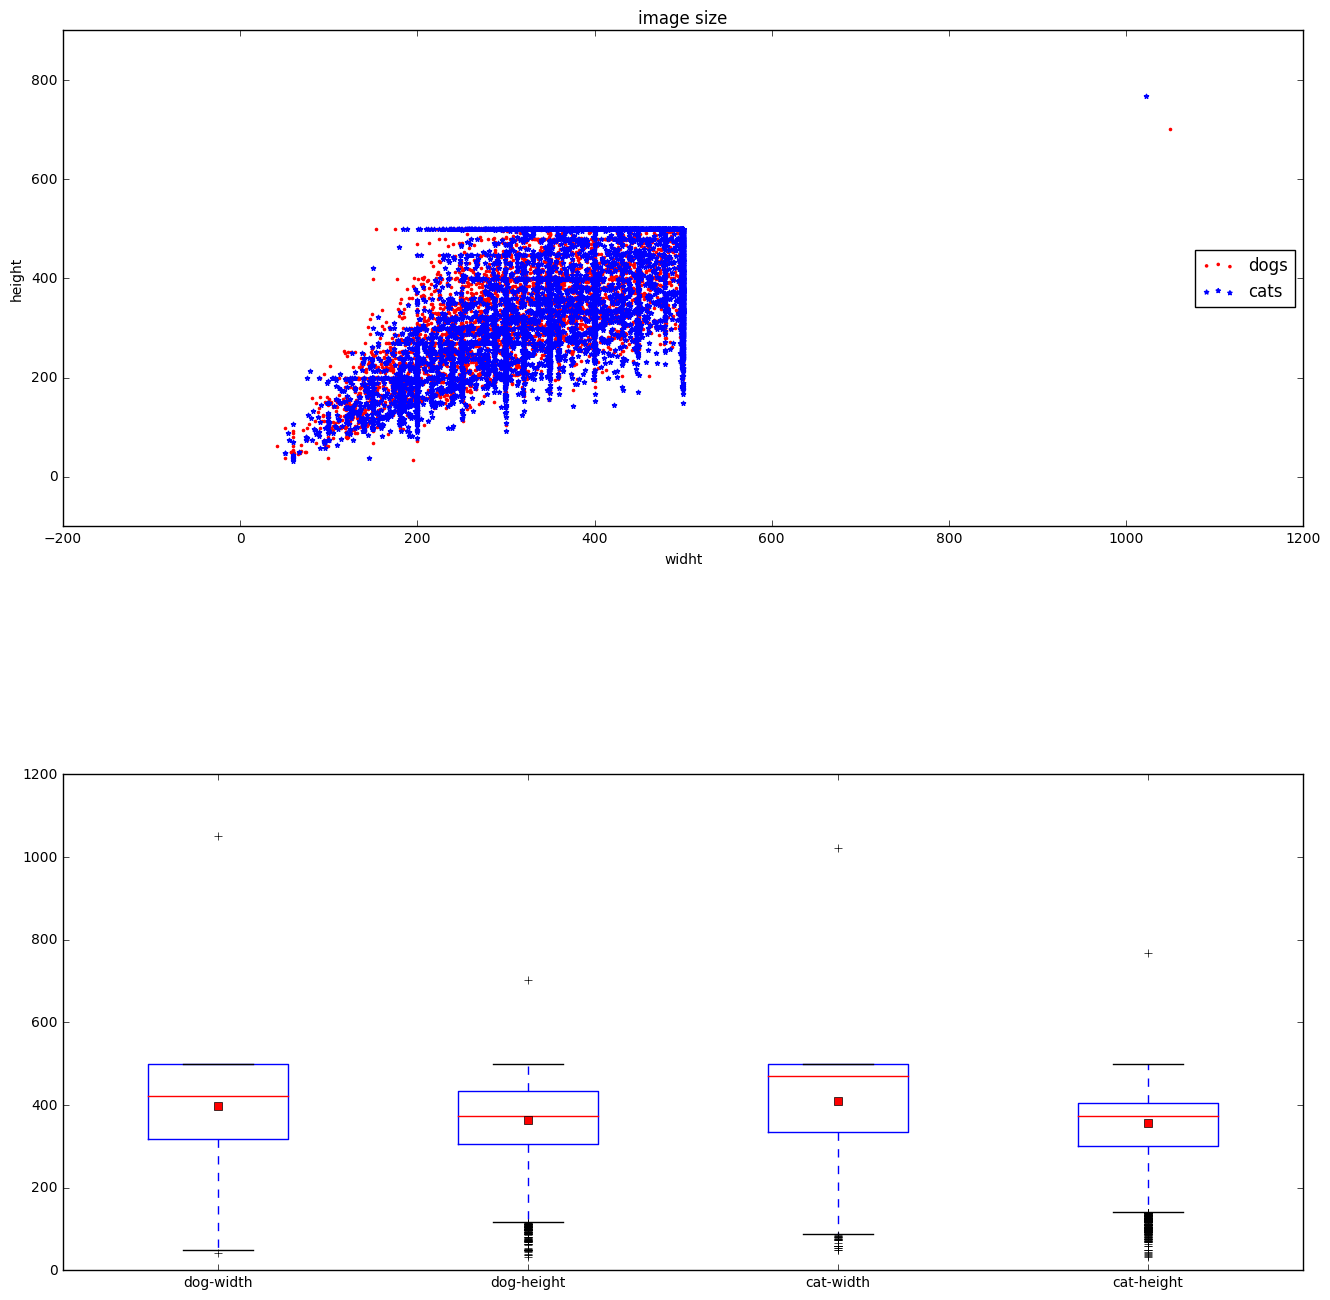


dogs width max/min:
               format mode width height
dog.2317.jpg    JPEG  RGB  1050    702
dog.10733.jpg   JPEG  RGB    42     62

dogs height max/min:
              format mode width height
dog.2317.jpg   JPEG  RGB  1050    702
dog.4367.jpg   JPEG  RGB   195     33

cats width max/mai:
               format mode width height
cat.835.jpg     JPEG  RGB  1023    768
cat.10392.jpg   JPEG  RGB    50     49

cats height max/min:
              format mode width height
cat.835.jpg    JPEG  RGB  1023    768
cat.6402.jpg   JPEG  RGB    60     32


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_image_properties(category_name):
    if category_name not in categories:
        raise Exception("\n category {{}] not exists.", category_name)
        
    category_map = {}
    path = cate_dat_dir + "/" + category_name + "/"
    filenames = os.listdir(path)
    for filename in filenames:
        im = Image.open(path + filename)
        category_map[filename] = [im.format, im.mode, im.width, im.height]
    return category_map

image_properties_dog = get_image_properties("dog")
image_properties_cat = get_image_properties("cat")

columns = ['format', 'mode', 'width', 'height']
df_dog = pd.DataFrame(image_properties_dog).transpose()
df_cat = pd.DataFrame(image_properties_cat).transpose()
df_dog.columns = columns
df_cat.columns = columns

print("\ndogs group by format, mode:")
print(df_dog.groupby(['format', 'mode'])['width'].count())
print("\ncats group by format, mode:")
print(df_cat.groupby(['format', 'mode'])['width'].count())

plt.figure(figsize=(16,16))
plt.subplot(2, 1, 1)
plt.scatter(x=df_dog['width'], y=df_dog['height'], s=10, marker=".", color='red')
plt.scatter(x=df_cat['width'], y=df_cat['height'], s=10, marker="*", color='blue')
plt.legend(['dogs','cats'], loc='center right')
plt.xlabel('widht')
plt.ylabel('height')
plt.title("image size")
plt.subplots_adjust(hspace = .5)

plt.subplot(2,1,2)
plt.boxplot([df_dog['width'], df_dog['height'], df_cat['width'], df_cat['height']], showmeans=True)
plt.xticks([1,2,3,4], ['dog-width', 'dog-height', 'cat-width', 'cat-height'])
#plt.subplots_adjust(hspace = .5)
plt.show()

print("\ndogs width max/min:\n",df_dog.loc[[df_dog['width'].idxmax(),df_dog['width'].idxmin()]])
print("\ndogs height max/min:\n",df_dog.loc[[df_dog['height'].idxmax(),df_dog['height'].idxmin()]])
print("\ncats width max/mai:\n",df_cat.loc[[df_cat['width'].idxmax(),df_cat['width'].idxmin()]])
print("\ncats height max/min:\n",df_cat.loc[[df_cat['height'].idxmax(),df_cat['height'].idxmin()]])

## 拆分训练集，验证集
将训练数据按7:3拆分成训练集和验证集

In [2]:
#========================3.split and preprocess data================================
import random

def split_train_valid(category_name, test_percent, random_seed=None, create_link=False):
    if category_name not in categories:
        raise Exception("\n category [{}] note exists.", category_name)
    if test_percent <=0 or test_percent >=1:
        raise Exception("\n test_percent must be in (0,1)")
        
    source_dir = cate_dat_dir + "/" + category_name + "/"
    dest_train_dir = train_dat_dir + "/" + category_name + "/"
    dest_valid_dir = valid_dat_dir + "/" + category_name + "/"
    
    filenames = os.listdir(source_dir)
    total_size = len(filenames)
    test_size = int(total_size * test_percent)
    train_size = total_size - test_size
    
    if not random_seed is None:
        random.seed(random_seed)
    random.shuffle(filenames)
    rebuild_dir(dest_train_dir)
    rebuild_dir(dest_valid_dir)
    for i in range(0, total_size):
        if i < test_size:
            dest_dir = dest_valid_dir
        else:
            dest_dir = dest_train_dir
        
        if create_link == True:
                os.symlink(source_dir + filenames[i], dest_dir + filenames[i])
        else:
                shutil.copy(source_dir + filenames[i], dest_dir)
                
    return train_size, test_size

## 搭建卷积网络
按以下步骤进行:
* 搭建网络结构
* 选择优化器,loss函数
* 预处理训练数据(rescale, shear, zoom, flip)
* 为防止过拟合采用EarlyStopping(monitor='val_loss', patience=5), 在验证loss上如果5次迭代后还没有下降，则停止模型训练
* 使用ModelCheckpoint(file_bath, "val_loss", verbose=1, save_best_only=True)，存储在验证集上表现最好的模型状态。
* 训练完成后可视化训练过程，方便进行调参
* 最后存储模型结构及模型权重。方便以后时行预测或重现。

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
274/274 [==============================] - 145s - loss: 0.6451 - acc: 0.5995 - val_loss: 0.5913 - val_acc: 0.6849
Epoch 2/150
274/274 [==============================] - 148s - loss: 0.5436 - acc: 0.7243 - val_loss: 0.5204 - val_acc: 0.7340
Epoch 3/150
274/274 [==============================] - 144s - loss: 0.5074 - acc: 0.7512 - val_loss: 0.4820 - val_acc: 0.7720
Epoch 4/150
274/274 [==============================] - 149s - loss: 0.4734 - acc: 0.7737 - val_loss: 0.4316 - val_acc: 0.7979
Epoch 5/150
274/274 [==============================] - 148s - loss: 0.4448 - acc: 0.7949 - val_loss: 0.4272 - val_acc: 0.7972
Epoch 6/150
274/274 [==============================] - 130s - loss: 0.4138 - acc: 0.8141 - val_loss: 0.4535 - val_acc: 0.7876
Epoch 7/150
274/274 [==============================] - 151s - loss: 0.3851 - acc: 0.8258 - val_loss: 0.3915 - val_acc: 0.8260
Epoch 8/150
274/274 [============

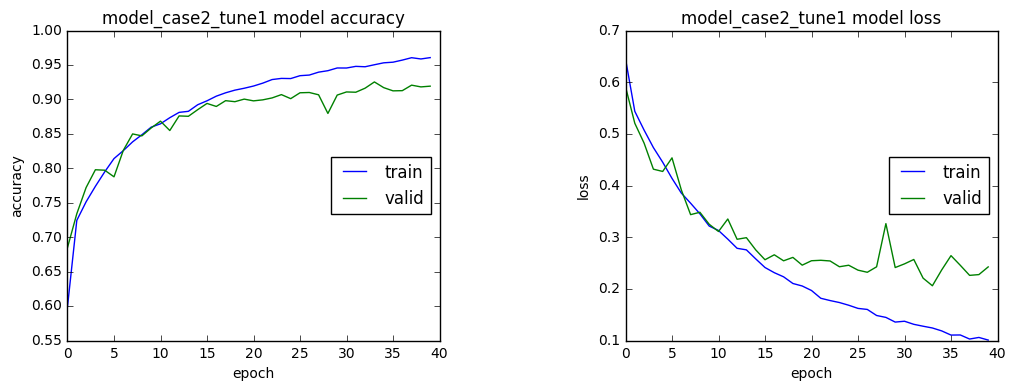

NameError: name 'history_vgg16_pre_tune2' is not defined

In [13]:
#model_case2_tune1
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras import optimizers
import pickle

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)
total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size

image_width = 150
image_height = 150
image_size = (image_width,image_height)
perbatch = 64
poch_num = 150

name_case2_tune1 = "model_case2_tune1"
model_case2_tune1 = ModelUtil.model_mycase2_tune1(image_width, image_height)
adam = optimizers.Adam(lr=0.0001)
rmsp = optimizers.RMSprop(lr=0.0001)
model_case2_tune1.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_case2_tune1, model_name=name_case2_tune1)
history_case2_tune1 = ModelUtil.train_data_earlystopping(model_case2_tune1, model_name=name_case2_tune1, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                         train_dir=train_dat_dir, train_size=total_train_size,
                         valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_case2_tune1, model_name=name_case2_tune1)


In [14]:
with open(name_case2_tune1+'.pickle', 'wb') as f:
    pickle.dump(history_case2_tune1.history, f)
ModelUtil.save_model(model_case2_tune1, model_name=name_case2_tune1)

1.然后搭建一个VGG16卷积网络，从头训练所有的权重，最后输出层以sigmoid激活。使用binary_crossentropy作为loss评估。

Using TensorFlow backend.


Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
547/547 [==============================] - 1129s - loss: 0.6679 - acc: 0.5717 - val_loss: 0.6384 - val_acc: 0.6161
Epoch 2/150
547/547 [==============================] - 1116s - loss: 0.5961 - acc: 0.6693 - val_loss: 0.5279 - val_acc: 0.7412
Epoch 3/150
547/547 [==============================] - 1117s - loss: 0.5471 - acc: 0.7168 - val_loss: 0.5232 - val_acc: 0.7351
Epoch 4/150
547/547 [==============================] - 1117s - loss: 0.5197 - acc: 0.7405 - val_loss: 0.4880 - val_acc: 0.7643
Epoch 5/150
547/547 [==============================] - 1117s - loss: 0.4940 - acc: 0.7608 - val_loss: 0.4780 - val_acc: 0.7695
Epoch 6/150
547/547 [==============================] - 1117s - loss: 0.4697 - acc: 0.7762 - val_loss: 0.4733 - val_acc: 0.7700
Epoch 7/150
547/547 [==============================] - 1118s - loss: 0.4465 - acc: 0.7911 - val_loss: 0.4217 - val_acc: 0.8076
Epoch 8/150
547/547 [=====

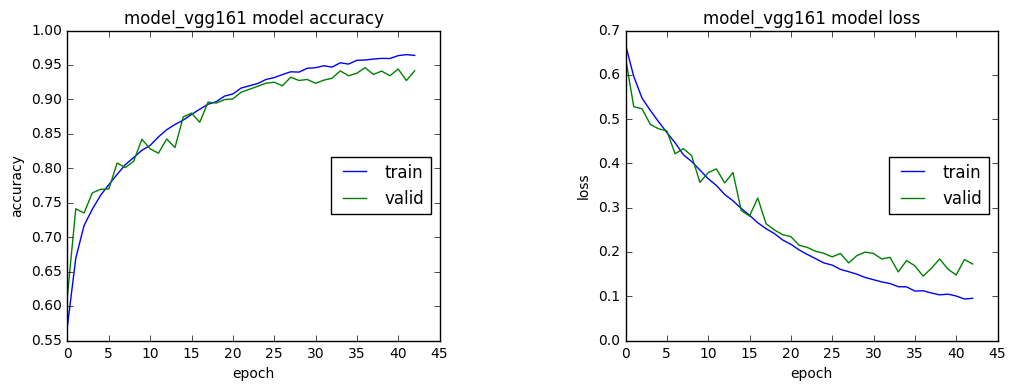

In [3]:
#model_vgg161
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers
import pickle

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 64
poch_num = 150


name_vgg161 = "model_vgg161"
model_vgg161 = ModelUtil.model_vgg161(image_width, image_height)
rmsp = optimizers.RMSprop(lr=0.00001)
model_vgg161.compile(optimizer=rmsp, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_vgg161, model_name=name_vgg161)
history_vgg161 = ModelUtil.train_data_earlystopping(model_vgg161, model_name=name_vgg161, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_vgg161, model_name=name_vgg161)
with open(name_vgg161 + '.pickle', 'wb') as f:
    pickle.dump(history_vgg161.history, f)
ModelUtil.save_model(model_vgg161, model_name=name_vgg161)

由于从头搭建的模型需要重新计算每一层的权重,而卷积神经网络的权重又很多，以上面搭建的为例，每一次迭代需要计算并更新TODO个权重,由于时间以及硬件资源的限制，后面将采用ImageNet己经预训练好的模型进行迁移学习，tensorflow目前提供VGG16， VGG19, ResNet, Xception,Inception等几种接口。这些预训练模型己经在更大规模的数据上训练过，且分类数也更多，达到1000个分类。通过直接加载预训练好的模型结构及其权重，针对本项目中的二分类问题进行输出块的改进。

2.首先加载VGG16并去掉top块，自己添加几层dense层，训练时保持VGG16原来的卷积块不变，只训练dense层，加块了训练速度，同时由于原VGG16的卷积层己具备的提取特征的功能，也使模型的表现有所提高。

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
274/274 [==============================] - 351s - loss: 0.6411 - acc: 0.6384 - val_loss: 0.5248 - val_acc: 0.8201
Epoch 2/150
274/274 [==============================] - 351s - loss: 0.5005 - acc: 0.7842 - val_loss: 0.3802 - val_acc: 0.8444
Epoch 3/150
274/274 [==============================] - 351s - loss: 0.4029 - acc: 0.8282 - val_loss: 0.2965 - val_acc: 0.8801
Epoch 4/150
274/274 [==============================] - 350s - loss: 0.3425 - acc: 0.8569 - val_loss: 0.2662 - val_acc: 0.8888
Epoch 5/150
274/274 [==============================] - 351s - loss: 0.3112 - acc: 0.8678 - val_loss: 0.2457 - val_acc: 0.9008
Epoch 6/150
274/274 [==============================] - 351s - loss: 0.2901 - acc: 0.8793 - val_loss: 0.2332 - val_acc: 0.9039
Epoch 7/150
274/274 [==============================] - 351s - loss: 0.2731 - acc: 0.8858 - val_loss: 0.2178 - val_acc: 0.9109
Epoch 8/150
274/274 [============

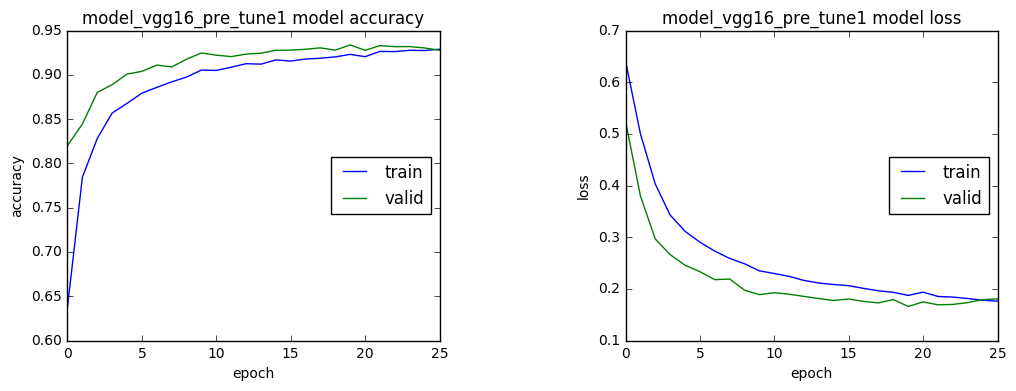

In [6]:
#model_vgg16_pre_tune1
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers
import pickle

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

#rebuild_dir(train_dat_dir)
#rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 64
poch_num = 150


name_vgg16_pre_tune1 = "model_vgg16_pre_tune1"
model_vgg16_pre_tune1 = ModelUtil.model_vgg16_pre_tune1(image_width, image_height)
rmsp = optimizers.RMSprop(lr=0.00001)
sgd = optimizers.SGD(lr=0.0001, momentum=0.9, decay=1e-6, nesterov=True)
model_vgg16_pre_tune1.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_vgg16_pre_tune1, model_name=name_vgg16_pre_tune1)
history_vgg16_pre_tune1 = ModelUtil.train_data_earlystopping(model_vgg16_pre_tune1, model_name=name_vgg16_pre_tune1, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_vgg16_pre_tune1, model_name=name_vgg16_pre_tune1)
with open(name_vgg16_pre_tune1 + '.pickle', 'wb') as f:
    pickle.dump(history_vgg16_pre_tune1.history, f)
ModelUtil.save_model(model_vgg16_pre_tune1, model_name=name_vgg16_pre_tune1)

3.后面加的卷积层过多，对模型的训练可能起到反作用。在训练过程中有可能导致卷积层的特征被训练没了。

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
137/137 [==============================] - 324s - loss: 0.3676 - acc: 0.8343 - val_loss: 0.3674 - val_acc: 0.8897
Epoch 2/150
137/137 [==============================] - 322s - loss: 0.2608 - acc: 0.8885 - val_loss: 0.2717 - val_acc: 0.8900
Epoch 3/150
137/137 [==============================] - 322s - loss: 0.2328 - acc: 0.9002 - val_loss: 0.2877 - val_acc: 0.8760
Epoch 4/150
137/137 [==============================] - 322s - loss: 0.2209 - acc: 0.9056 - val_loss: 0.1770 - val_acc: 0.9304
Epoch 5/150
137/137 [==============================] - 322s - loss: 0.2153 - acc: 0.9083 - val_loss: 0.1923 - val_acc: 0.9205
Epoch 6/150
137/137 [==============================] - 322s - loss: 0.2071 - acc: 0.9124 - val_loss: 0.1873 - val_acc: 0.9225
Epoch 7/150
137/137 [==============================] - 322s - loss: 0.2054 - acc: 0.9142 - val_loss: 0.1797 - val_acc: 0.9259
Epoch 8/150
137/137 [============

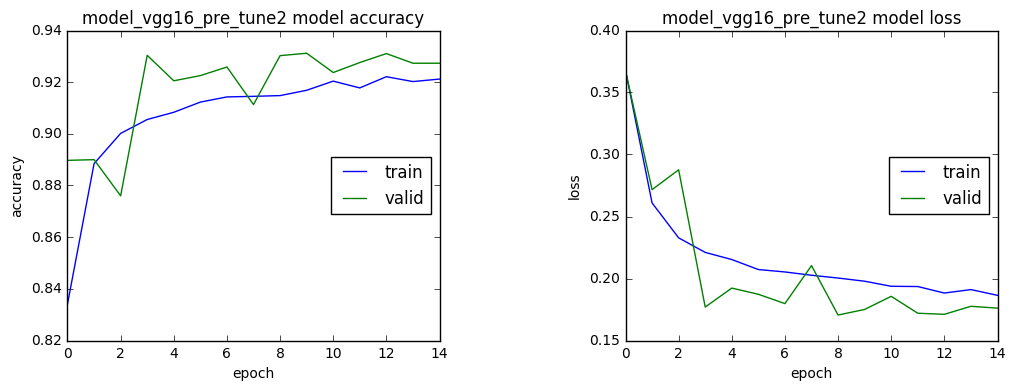

In [10]:
#model_vgg16_pre_tune2
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers
import pickle

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

#rebuild_dir(train_dat_dir)
#rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 64
poch_num = 150


name_vgg16_pre_tune2 = "model_vgg16_pre_tune2"
model_vgg16_pre_tune2 = ModelUtil.model_vgg16_pre_tune2(image_width, image_height)
rmsp = optimizers.RMSprop(lr=0.00001)
sgd = optimizers.SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True)
adam = optimizers.Adam(lr=1e-3)
model_vgg16_pre_tune2.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_vgg16_pre_tune2, model_name=name_vgg16_pre_tune2)
history_vgg16_pre_tune2 = ModelUtil.train_data_earlystopping(model_vgg16_pre_tune2, model_name=name_vgg16_pre_tune2, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_vgg16_pre_tune2, model_name=name_vgg16_pre_tune2)
with open(name_vgg16_pre_tune2 + '.pickle', 'wb') as f:
    pickle.dump(history_vgg16_pre_tune2.history, f)
ModelUtil.save_model(model_vgg16_pre_tune2, model_name=name_vgg16_pre_tune2)

choosed:换ResNet进行训练，发现要比VGG16效果好很多，虽然ResNet网络层数比VGG16多，但是训练速度却快很多。因为ResNet网络结构，以及权重数。。。。
加上ResNet的结构说明。

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D) (None, 230, 230, 3)   0           input_2[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_2[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

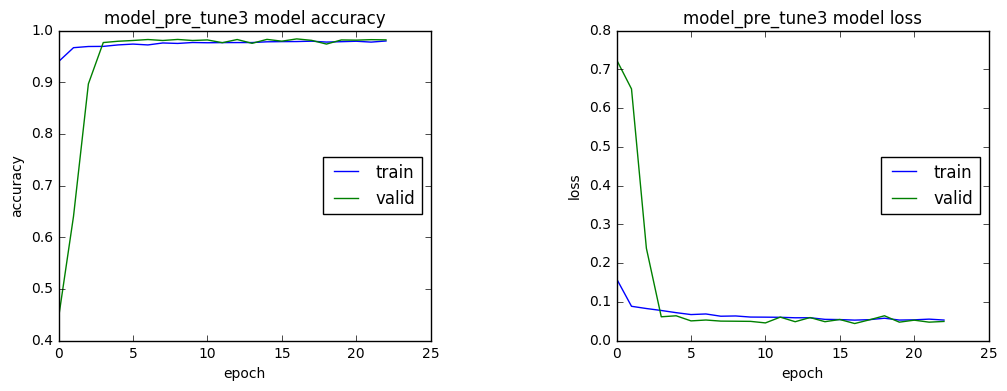

Found 18 images belonging to 1 classes.
0 test/cat.21.jpg [ 1.]
1 test/dog.51.jpg [ 1.]
2 test/dog.71.jpg [ 1.]
3 test/dog.91.jpg [ 1.]
4 test/cat.41.jpg [ 1.]
5 test/cat.11.jpg [ 1.]
6 test/dog.41.jpg [ 1.]
7 test/cat.91.jpg [ 1.]
8 test/dog.11.jpg [ 1.]
9 test/cat.71.jpg [ 1.]
10 test/cat.51.jpg [ 1.]
11 test/dog.61.jpg [ 1.]
12 test/cat.31.jpg [ 1.]
13 test/dog.81.jpg [ 1.]
14 test/cat.81.jpg [ 1.]
15 test/cat.61.jpg [ 1.]
16 test/dog.21.jpg [ 1.]
17 test/dog.31.jpg [ 1.]


In [4]:
#model_pre_tune3

import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import pickle

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500
total_valid_size = 7500 
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 64
poch_num = 150


name_pre_tune3 = "model_pre_tune3"
model_pre_tune3 = ModelUtil.model_pre_tune3(image_width, image_height)
sgd = optimizers.SGD(lr=1e-4, momentum=0.9)
adam = optimizers.Adam(lr=1e-3)

model_pre_tune3.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_pre_tune3, model_name=name_pre_tune3)
history_pre_tune3 = ModelUtil.train_data_earlystopping(model_pre_tune3, model_name=name_pre_tune3, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
with open(name_pre_tune3 + '.pickle', 'wb') as f:
    pickle.dump(history_pre_tune3.history, f)
ModelUtil.visualize_history(history_pre_tune3, model_name=name_pre_tune3)

ModelUtil.predict_small_data(model_pre_tune3, "./visual_images", image_width, image_height, perbatch)
ModelUtil.save_model(model_pre_tune3, model_name=name_pre_tune3)

在测试数据上预测模型, 先将clip屏蔽掉，查看Kaggle评分，然后再加上clip进行结果上传评分。

In [26]:
from keras.models import model_from_json
import ModelUtil
import importlib
importlib.reload(ModelUtil)

image_width = 224
image_height = 224
perbatch = 64

chosed_model_name="model_pre_tune3"
chosed_model = model_from_json(open(chosed_model_name + '.json').read())
chosed_model.load_weights(chosed_model_name + '.h5')

ModelUtil.predict_data(chosed_model, model_name=chosed_model_name, 
                image_size=(image_width, image_height), 
                num_perbatch=perbatch)

OSError: Unable to open file (Unable to open file: name = 'model_pre_tune3.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

可视化ResNet卷积层

In [30]:
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from quiver_engine import server
from keras import applications

image_width = 224
image_height = 224
perbatch = 64


model_name="model_pre_tune3"
model = model_from_json(open(model_name + '.json').read())
model.load_weights(model_name + '_top.h5')

server.launch(model,  classes=['cat','dog'], input_folder="./visual_images/test", port=7000)

[array([[ 1.34112203,  1.27761042,  0.        , ...,  0.88032359,
         5.59820223,  1.06639194]], dtype=float32), array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.21414042e-38,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          8.06510849e-30,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00

NameError: name 'y_classes' is not defined